In [1]:
#NOTE: use python env acmil in ACMIL folder
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

import matplotlib
matplotlib.use('Agg')
import pandas as pd
import warnings
import torch
import torch.nn as nn

from pathlib import Path
import PIL
from skimage import filters
import random

    
sys.path.insert(0, '../Utils/')
from Utils import create_dir_if_not_exists
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
####################################
######      USERINPUT       ########
####################################
cohort = "TMA" #TEST， TMA
s_outcome = "ROC_AUC" #PR_AUC
feature_extraction_method = 'retccl' #retccl, uni1

proj_dir = '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out02122025/'
perf_dir = proj_dir + feature_extraction_method + '/TrainOL100_TestOL0_TFT0.9/'


###OLD
#perf_dir = "/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out02062025/retccl/" 
#perf_dir2 = perf_dir + "MAXSSALLTUMORTILES_TrainOL100_TestOL0_TRAINTEST_TFT0.9_TMA_TFT" + str(TMA_TFT) + "/split_fold0/DL_emb_only/MT/perf/"




In [3]:
#Load all N of tokens perfoermence for all fold
perf_list = []
for i in range(0,4):
    perf_dir2 = perf_dir + "FOLD" + str(i) + "/MT/perf/"
    for j in range(2,10):
        perf_df = pd.read_csv(perf_dir2+ 'n_token' + str(j) + '_' + cohort + '_perf.csv')
        perf_df['FOLD'] = i
        perf_df['N_TOKENS'] = j
        perf_list.append(perf_df)
all_perf_df = pd.concat(perf_list)
all_perf_df.rename(columns = {'AUC': 'ROC_AUC'}, inplace = True)
all_perf_df.loc[all_perf_df['OUTCOME'] == 'MMR (MSH2, MSH6, PMS2, MLH1, MSH3, MLH3, EPCAM)2','OUTCOME'] = 'HR'
all_perf_df.loc[all_perf_df['OUTCOME'] == 'TMB_HIGHorINTERMEDITATE','OUTCOME'] = 'TMB_HIGH'

In [4]:
# CV PERforamnce: Calculate the average of ROCAUC for each OUTCOME across Folds
average_across_folds_df = all_perf_df.groupby(['OUTCOME','N_TOKENS'])[['ROC_AUC', 'ACC', 'F1', 'F2', 'F3', 'Recall', 'Precision','Specificity', 'PR_AUC']].mean().reset_index()
std_across_folds_df = all_perf_df.groupby(['OUTCOME','N_TOKENS'])[['ROC_AUC', 'ACC', 'F1', 'F2', 'F3', 'Recall', 'Precision','Specificity', 'PR_AUC']].std().reset_index()
#AVERAGE across n_tokens for all outcomes
average_across_tokens_df = average_across_folds_df.groupby('N_TOKENS')[['ROC_AUC', 'ACC', 'F1', 'F2', 'F3', 'Recall', 'Precision','Specificity', 'PR_AUC']].mean().reset_index()
average_across_tokens_df['OUTCOME'] = 'AVERAGE'
average_across_tokens_df = average_across_tokens_df[average_across_folds_df.columns]
all_perf_df_avg = pd.concat([average_across_folds_df, average_across_tokens_df], ignore_index=True)

#AVG of STD across n_tokens for all outcomes
std_across_tokens_df = std_across_folds_df.groupby('N_TOKENS')[['ROC_AUC', 'ACC', 'F1', 'F2', 'F3', 'Recall', 'Precision','Specificity', 'PR_AUC']].mean().reset_index()
std_across_tokens_df['OUTCOME'] = 'AVERAGE'
std_across_tokens_df = std_across_tokens_df[std_across_folds_df.columns]

all_perf_df_std = pd.concat([std_across_folds_df, std_across_tokens_df], ignore_index=True)
all_perf_df_std.rename(columns = {'ROC_AUC': 'ROC_AUC_STD',
                                 'ACC': 'ACC_STD',
                                 'F1': 'F1_STD',
                                 'F2': 'F2_STD',
                                 'F3': 'F3_STD',
                                 'Recall': 'Recall_STD',
                                 'Precision': 'Precision_STD',
                                 'Specificity': 'Specificity_STD',
                                 'PR_AUC': 'PR_AUC_STD'}, inplace = True)

all_perf_df = all_perf_df_avg.merge(all_perf_df_std, on = ['OUTCOME','N_TOKENS'])
all_perf_df.to_csv(perf_dir  + "ALL_" + cohort + "_perf.csv",index = True)

In [5]:
# Create scatter plot
plot_df = all_perf_df[['OUTCOME','N_TOKENS','ROC_AUC', 'ACC', 'F1', 'F2', 'F3', 'Recall', 'Precision','Specificity', 'PR_AUC']].copy()

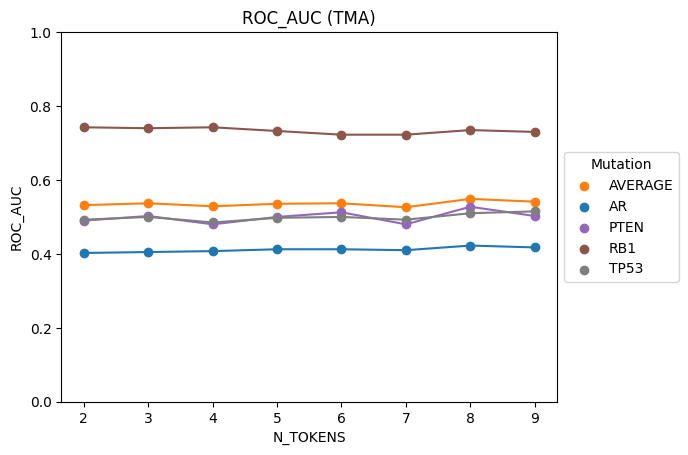

In [6]:
tab10 = plt.get_cmap('tab10')
# Define custom colors for each group
colors = {
    'AR': tab10(0),       # First color in tab10
    'AVERAGE': tab10(1),  # Second color in tab10
    'HR': tab10(2),       # Third color in tab10
    'MSI_POS': tab10(3),  # Fourth color in tab10
    'PTEN': tab10(4),     # Fifth color in tab10
    'RB1': tab10(5),      # Sixth color in tab10
    'TMB_HIGH': tab10(6), # Seventh color in tab10
    'TP53': tab10(7)      # Eighth color in tab10
}

# Create scatter plot with grouping
groups = plot_df.groupby('OUTCOME')
for name, group in groups:
    plt.scatter(group['N_TOKENS'], group[s_outcome], label=name, color=colors.get(name, 'black'))
    plt.plot(group['N_TOKENS'], group[s_outcome], color=colors.get(name, 'black'))


# Create a custom order for the legend
handles, labels = plt.gca().get_legend_handles_labels()
order = ['AVERAGE'] + [label for label in labels if label != 'AVERAGE']
ordered_handles = [handles[labels.index(label)] for label in order]

# Add title and labels
plt.title(s_outcome + ' (' + cohort +  ')')
plt.xlabel('N_TOKENS')
plt.ylabel(s_outcome)
plt.ylim(0, 1)
plt.legend(ordered_handles, order, title='Mutation', loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(perf_dir + s_outcome + '_' + cohort + '_scatter_plot.png', bbox_inches='tight')
# Show plot
plt.show()

In [7]:
round(all_perf_df.loc[all_perf_df['OUTCOME'] == 'AVERAGE']['ROC_AUC'],2)

32    0.53
33    0.54
34    0.53
35    0.54
36    0.54
37    0.53
38    0.55
39    0.54
Name: ROC_AUC, dtype: float64

In [8]:
#Get patient-level prediction